In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import Image
import imageio
import csv

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from iLQR import iLQR, Path

In [2]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

/tmp/ipykernel_66816/2610001736.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


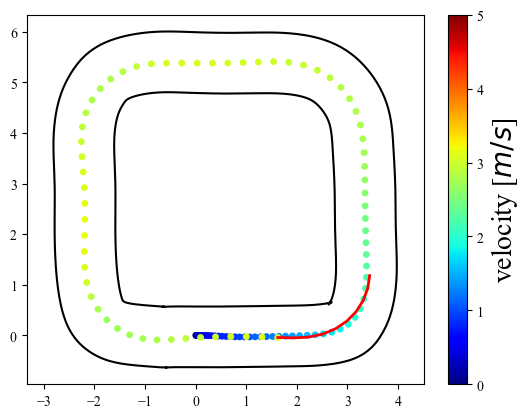

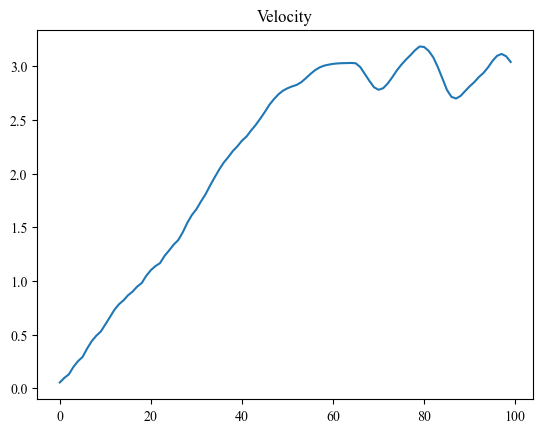

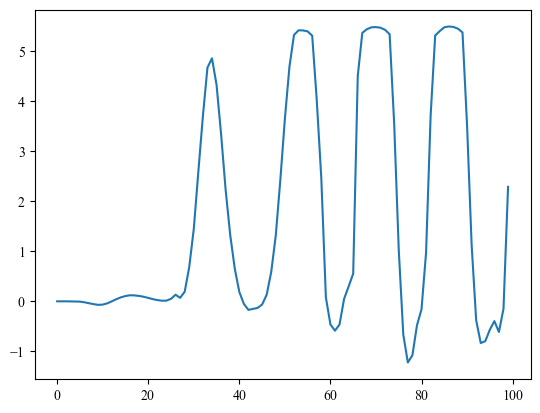

In [170]:
# Load ILQR
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)
solver = iLQR()
solver.update_path(path)

# define some parameters
n = 10
itr_receding = 100
x_cur = np.array([0, 0, 4, 0, 0])  # Initial state.
init_control = np.zeros((2, n))
fig_prog_folder = 'fig/'

state_history = np.zeros((5,itr_receding))
for i in range(itr_receding):
    plan = solver.plan(x_cur, init_control)
    states = plan['states']
    controls = plan['controls']
    x_cur = states[:,1]
    state_history[:,i]  = x_cur
    init_control[:,:-1] = controls[:,1:]
    
    # plot
    plt.clf()
    path.plot_track()
    sc = plt.scatter(
        state_history[0, :i], state_history[1, :i], s=24,
        c=state_history[2, :i], cmap=cm.jet, vmin=0, vmax=5,
        edgecolor='none', marker='o'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label(r"velocity [$m/s$]", size=20)
    
    plt.plot(states[0, :], states[1, :], 'r', linewidth=2)
    plt.axis('equal')
    plt.savefig(os.path.join(fig_prog_folder, str(i)+".png"), dpi=200)
plt.close('All')

gif_path = os.path.join(fig_prog_folder, 'rollout.gif')
with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(itr_receding):
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)
Image(open(gif_path,'rb').read(), width=400)

plt.figure()
plt.plot(state_history[2,:])
plt.title('Velocity')


plt.figure()
a = state_history[2, :]**2 / 0.257 * np.tan(state_history[-1, :])
plt.plot(a)


In [ ]:
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)
solver = iLQR()
solver.update_path(path)

x_cur = np.array([3.41826892, 3.26030934, 2.88551211, 1.51112723, -0.15])
plan = solver.plan(x_cur)
path.plot_track()
plt.plot(plan['states'][0, :], plan['states'][1, :], 'r', linewidth=2)

print(plan['status'])

